# Загрузка данных

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd 
covid_data = pd.read_csv('gdrive/My Drive/Advanced_ML/owid-covid-data.csv')

In [ ]:
covid_data_Russia = covid_data.loc[covid_data.location == 'Russia']
begin_data = covid_data_Russia.index[covid_data_Russia['date'] == '2020-03-03'].tolist()
end_data = covid_data_Russia.index[covid_data_Russia['date'] == '2022-02-21'].tolist()

In [ ]:
train_total_cases = covid_data_Russia.loc[begin_data[0] : begin_data[0] + 49] [['total_cases']]
train_new_cases = covid_data_Russia.loc[begin_data[0] : begin_data[0] + 49] [['new_cases']]
numbers = [i for i in range(50)]
train_total_cases.index = numbers
train_new_cases.index = numbers
train_x = pd.DataFrame({'numbers' : numbers})

In [ ]:
test_total_cases = covid_data_Russia.loc[begin_data[0] + 50 :] [['total_cases']]

test_new_cases = covid_data_Russia.loc[begin_data[0] + 50 : ] [['new_cases']]

numbers = [i for i in range(50, end_data[0] - begin_data[0] + 1)]
test_total_cases.index = numbers
test_new_cases.index = numbers

test_x = pd.DataFrame({'numbers' : numbers})

In [ ]:
train_new_cases.new_cases[train_new_cases.new_cases == 0] = 1;
test_new_cases.new_cases[test_new_cases.new_cases == 0] = 1;

## Графики целевых переменных

<Figure size 432x288 with 0 Axes>

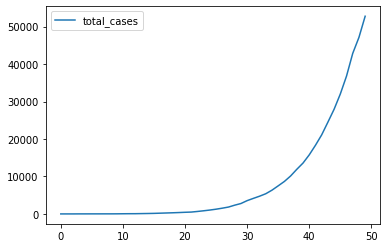

In [ ]:
#train_total_cases
from matplotlib import pyplot as plt
plt.figure();
train_total_cases.plot();

<Figure size 432x288 with 0 Axes>

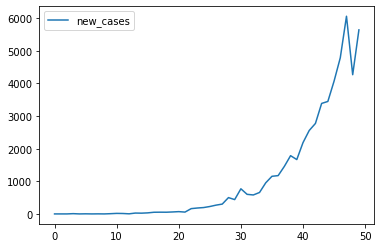

In [ ]:
#train_new_cases
plt.figure();
train_new_cases.plot();

<Figure size 432x288 with 0 Axes>

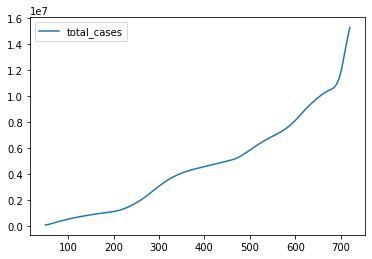

In [ ]:
#test_total_cases
plt.figure();
test_total_cases.plot();

<Figure size 432x288 with 0 Axes>

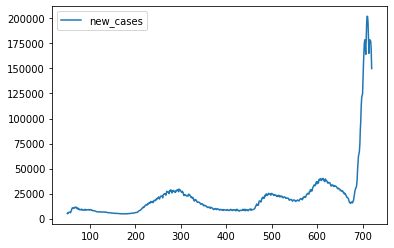

In [ ]:
#test_new_cases
plt.figure();
test_new_cases.plot();

# Модель с экспоненциальным ростом числа заболевших

In [ ]:
# логарифмируем данные
import numpy as np
train_total_cases_log = np.log(train_total_cases)
train_new_cases_log  = np.log(train_new_cases)
test_total_cases_log = np.log(test_total_cases)
test_new_cases_log = np.log(test_new_cases)
train_total_cases_log.tail()

,total_cases
45,10.373741
46,10.513063
47,10.665531
48,10.760474
49,10.873565


<Figure size 432x288 with 0 Axes>

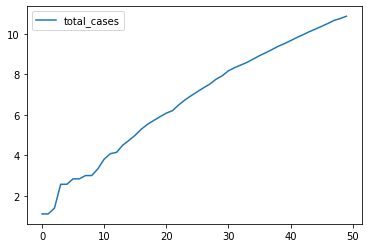

In [ ]:
#train_total_cases_log
plt.figure();
train_total_cases_log.plot();

<Figure size 432x288 with 0 Axes>

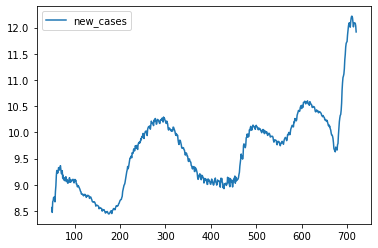

In [ ]:
#test_new_cases_log
plt.figure();
test_new_cases_log.plot();

In [ ]:
cur_mu_t, cur_sigma_t = np.array([0, 0]), 2*np.array([[2, 0], [0, 2]])
cur_mu_n, cur_sigma_n = np.array([0, 0]), 2*np.array([[2, 0], [0, 2]])

In [ ]:
N = 50
xs = np.linspace(0, 50 , N)

In [ ]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((min(points[1]), max(points[1])))
    plt.xlim((min(points[0]), max(points[0])))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

In [ ]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [ ]:
px = []
py_total_cases = []
py_new_cases = []
for i in range(50):
  px.append(i)
  py_total_cases.append(train_total_cases_log['total_cases'][i])
  py_new_cases.append(train_new_cases_log['new_cases'][i])

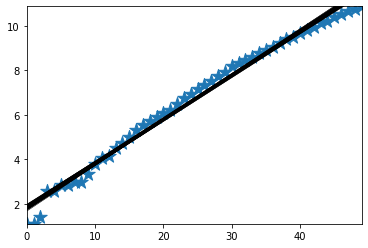

In [ ]:
#train_total_cases_log
for i in range(50):
  cur_mu_t, cur_sigma_t = bayesian_update(cur_mu_t, cur_sigma_t, px[i], train_total_cases_log['total_cases'][i])
myplot_sample_lines(cur_mu_t, cur_sigma_t, 100, points=[px, train_total_cases_log['total_cases']])

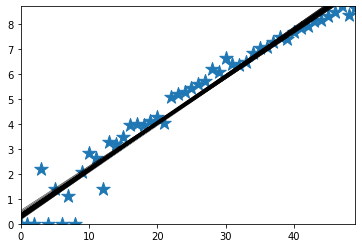

In [ ]:
#train_new_cases_log
for i in range(50):
  cur_mu_n, cur_sigma_n = bayesian_update(cur_mu_n, cur_sigma_n, px[i], train_new_cases_log['new_cases'][i])
myplot_sample_lines(cur_mu_n, cur_sigma_n, 100, points=[px, train_new_cases_log['new_cases']])

In [ ]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [ ]:
# Нарисуем результат
legend_fontsize = 16
figsize = (15, 15)
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((0, 20))
    ax.plot(xs, points[1], label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    
    sigma = sum((points[1] - mu[1] * xs - mu[0]) ** 2) / len(points[0])
    print('дисперсия шума ', sigma ** 0.5)
    ax.fill_between(xs, mu[1]*xs + mu[0] - sigma ** 0.5, mu[1]*xs + mu[0] + sigma ** 0.5,  color = 'orange', alpha=0.7, label="дисперсия шума")
    
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

дисперсия шума  2.5988484287108715


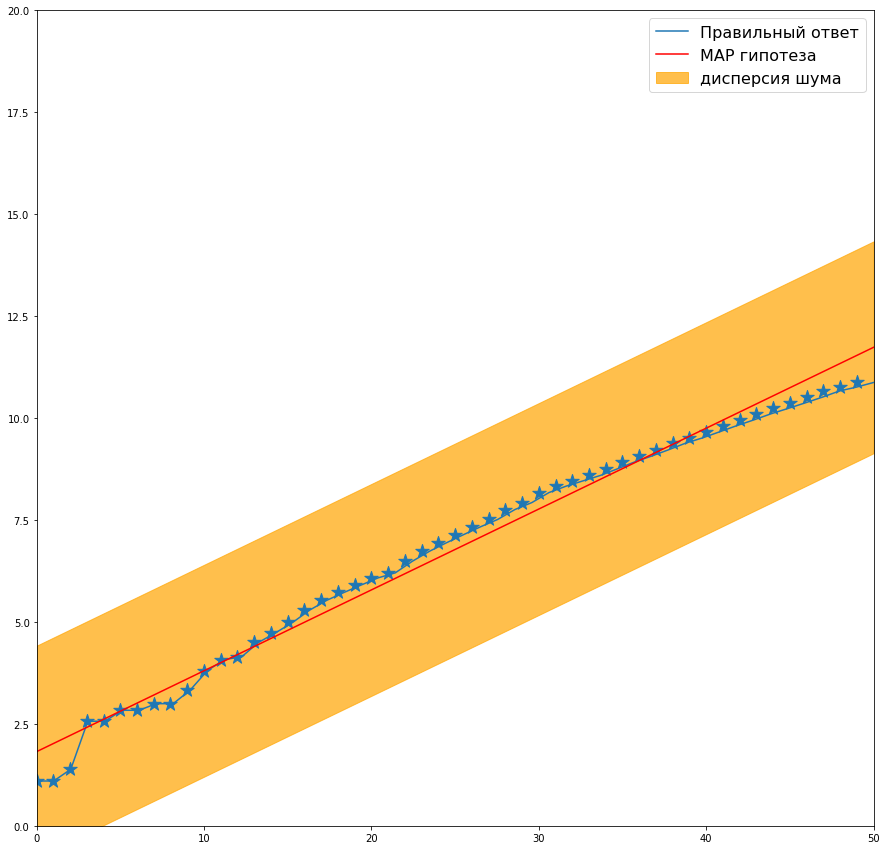

In [ ]:
x = sample_statistics(cur_mu_t, cur_sigma_t, xs, n=100)
plot_predictions(xs, cur_mu_t, x, [[px], train_total_cases_log['total_cases']])

дисперсия шума  4.283428157949005


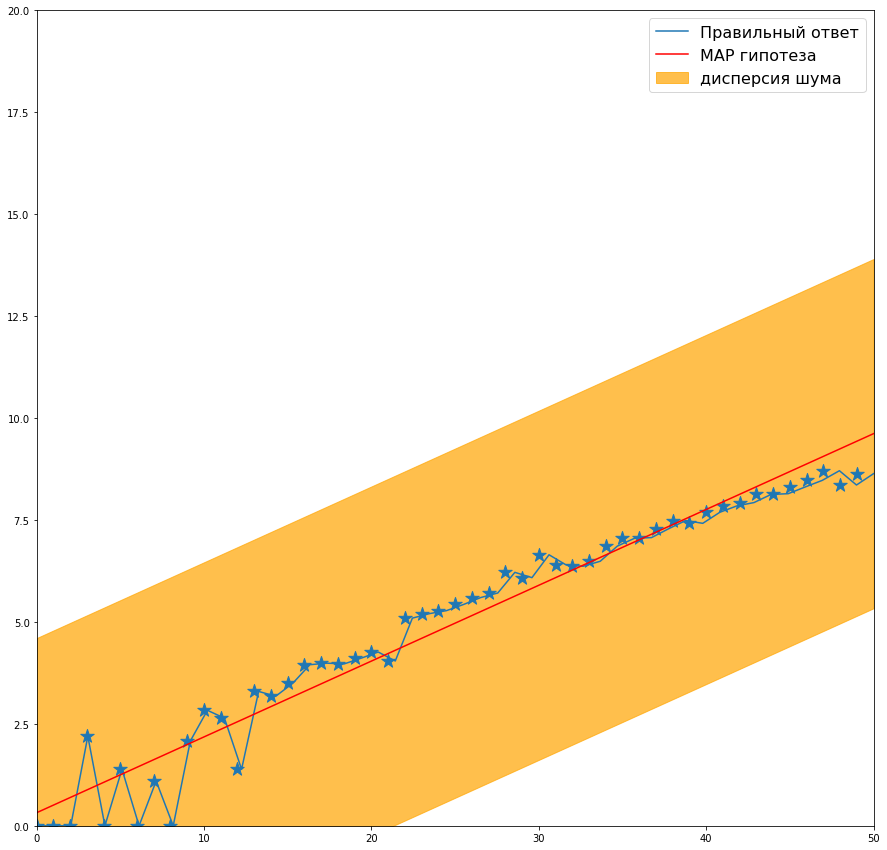

In [ ]:
x = sample_statistics(cur_mu_n, cur_sigma_n, xs, n = 100)
plot_predictions(xs, cur_mu_n, x, [[px], train_new_cases_log['new_cases']])

#### Предсказания случаев коронавируса в России к 1 мая, к 1 июня, к 1 сентября

In [ ]:
import datetime
date0 = datetime.datetime(2020, 3, 3)#2020-03-03
date1 = datetime.datetime(2020, 5, 1)#1 мая
date2 = datetime.datetime(2020, 6, 1)#1 июня
date3 = datetime.datetime(2020, 9, 1)#1 сентября
date_1_5 = date1 - date0
date_1_6 = date2 - date0
date_1_9 = date3 - date0

In [ ]:
px = [date_1_5.days, date_1_6.days, date_1_9.days]
py_t = [test_total_cases_log['total_cases'][date_1_5.days], test_total_cases_log['total_cases'][date_1_6.days],\
      test_total_cases_log['total_cases'][date_1_9.days]]
py_n = [test_new_cases_log['new_cases'][date_1_5.days], test_new_cases_log['new_cases'][date_1_6.days],\
      test_new_cases_log['new_cases'][date_1_9.days]]

In [ ]:
N = date_1_9.days - 50
xs = np.linspace(50, date_1_9.days , N)

In [ ]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1] * xs), 'k-', lw=.4)
    plt.plot(xs, np.exp(mu[0] + mu[1] * xs), 'r-', lw=.9)
    print('Предсказание для 1 мая ', int(np.exp(mu[0] + mu[1] * points[0][0])))
    print('Предсказание для 1 июня ', int(np.exp(mu[0] + mu[1] * points[0][1])))
    print('Предсказание для 1 сентября ', int(np.exp(mu[0] + mu[1] * points[0][2])))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

Предсказание для 1 мая  745364
Предсказание для 1 июня  349044741
Предсказание для 1 сентября  29394916851393328


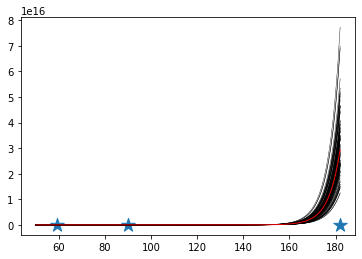

In [ ]:
#test_total_cases
myplot_sample_lines(cur_mu_t, cur_sigma_t, 100, points=[px, py_t])

Предсказание для 1 мая  80242
Предсказание для 1 июня  25597844
Предсказание для 1 сентября  689978026642679


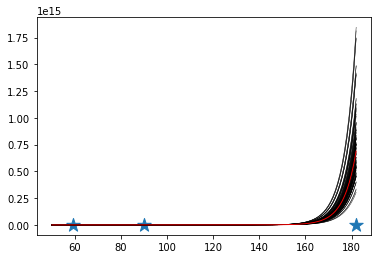

In [ ]:
#test_new_cases
myplot_sample_lines(cur_mu_n, cur_sigma_n, 100, points=[px, py_n])

# Модель с ростом числа заболевших функции распределения для гауссиана

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
xs = np.arange(50).reshape(-1, 1)
xs = np.concatenate((xs, xs ** 2), axis=1)

In [ ]:
xs_t = np.arange(50, 720).reshape(-1, 1)
xs_t = np.concatenate((xs_t, xs_t ** 2), axis=1)

In [ ]:
reg = LinearRegression().fit(xs, train_total_cases_log)
print(reg.score(xs, train_total_cases_log))
print(reg.coef_)
print(reg.intercept_)

0.9976424849770591
[[ 0.28245677 -0.00171767]]
[1.14741031]


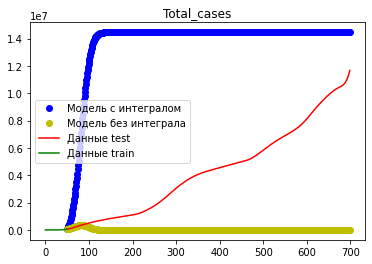

In [ ]:
#Total_cases
plt.plot(np.arange(50, 700).reshape(-1, 1), np.cumsum(np.exp(reg.predict(xs_t[:650]))), 'bo', label= 'Модель с интегралом')
plt.plot(np.arange(50, 700).reshape(-1, 1), np.exp(reg.predict( xs_t[:650])), 'yo', label='Модель без интеграла')
plt.plot(np.arange(50, 700).reshape(-1, 1), test_total_cases[:650], 'r', label='Данные test')
plt.plot(np.arange(50).reshape(-1, 1), train_total_cases, color='g',  label='Данные train')
plt.title('Total_cases')
plt.legend()
plt.show()

In [ ]:
reg = LinearRegression().fit(xs, train_new_cases_log)
print(reg.score(xs, train_new_cases_log))
print(reg.coef_)
print(reg.intercept_)

0.9683360173111185
[[ 0.27562283 -0.00182979]]
[-0.3965904]


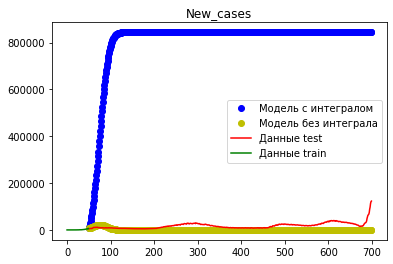

In [ ]:
plt.plot(np.arange(50, 700).reshape(-1, 1), np.cumsum(np.exp(reg.predict(xs_t[:650]))), 'bo', label= 'Модель с интегралом')
plt.plot(np.arange(50, 700).reshape(-1, 1), np.exp(reg.predict(xs_t[:650])), 'yo', label='Модель без интеграла')
plt.plot(np.arange(50, 700).reshape(-1, 1), test_new_cases[:650], 'r', label='Данные test')
plt.plot(np.arange(50).reshape(-1, 1), train_new_cases, color='g',  label='Данные train')
plt.title('New_cases')
plt.legend()
plt.show()

# Предсказания для Австралии

In [ ]:
covid_data_Australia = covid_data.loc[covid_data.location == 'Australia']
begin_data = covid_data_Australia.index[covid_data_Australia['date'] == '2020-02-29'].tolist()
end_data = covid_data_Australia.index[covid_data_Australia['date'] == '2022-02-21'].tolist()

In [ ]:
train_total_cases = covid_data_Australia.loc[begin_data[0] : begin_data[0] + 49] [['total_cases']]
train_new_cases = covid_data_Australia.loc[begin_data[0] : begin_data[0] + 49] [['new_cases']]
numbers = [i for i in range(50)]
train_total_cases.index = numbers
train_new_cases.index = numbers
train_x = pd.DataFrame({'numbers' : numbers})

In [ ]:
train_new_cases.new_cases[train_new_cases.new_cases == 0] = 1;
test_new_cases.new_cases[test_new_cases.new_cases == 0] = 1;

In [ ]:
test_total_cases = covid_data_Australia.loc[begin_data[0] + 50 :] [['total_cases']]
test_new_cases = covid_data_Australia.loc[begin_data[0] + 50 : ] [['new_cases']]

numbers = [i for i in range(50, end_data[0] - begin_data[0] + 1)]
test_total_cases.index = numbers
test_new_cases.index = numbers

test_x = pd.DataFrame({'numbers' : numbers})

<Figure size 432x288 with 0 Axes>

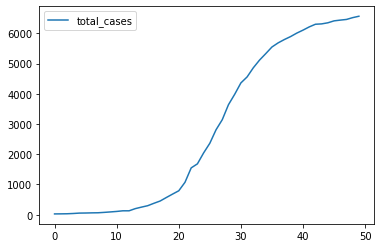

In [ ]:
#train_total_cases
from matplotlib import pyplot as plt
plt.figure();
train_total_cases.plot();

<Figure size 432x288 with 0 Axes>

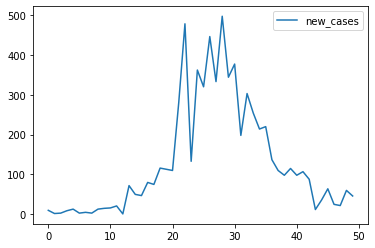

In [ ]:
#train_new_cases
plt.figure();
train_new_cases.plot();

<Figure size 432x288 with 0 Axes>

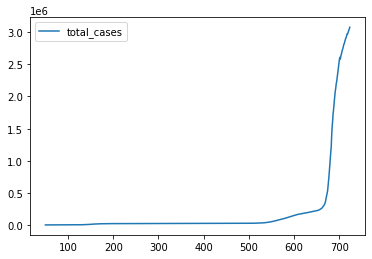

In [ ]:
#test_total_cases
plt.figure();
test_total_cases.plot();

<Figure size 432x288 with 0 Axes>

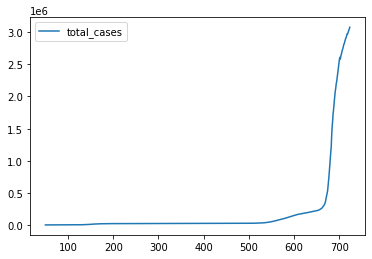

In [ ]:
#test_total_cases
plt.figure();
test_total_cases.plot();

In [ ]:
# логарифмируем данные
import numpy as np
train_total_cases_log = np.log(train_total_cases)
train_new_cases_log  = np.log(train_new_cases)
test_total_cases_log = np.log(test_total_cases)
test_new_cases_log = np.log(test_new_cases)
train_total_cases_log.tail()

,total_cases
45,8.766394
46,8.770284
47,8.773694
48,8.782936
49,8.789965


In [ ]:
reg = LinearRegression().fit(xs, train_total_cases_log)
print(reg.score(xs, train_total_cases_log))
print(reg.coef_)
print(reg.intercept_)

0.98423447223833
[[ 0.26682141 -0.00284603]]
[2.64466934]


In [ ]:
# Russia
# 0.9976424849770591
# [[ 0.28245677 -0.00171767]]
# [1.14741031]

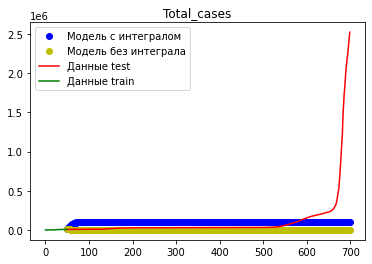

In [ ]:
#Total_cases
plt.plot(np.arange(50, 700).reshape(-1, 1), np.cumsum(np.exp(reg.predict(xs_t[:650]))), 'bo', label= 'Модель с интегралом')
plt.plot(np.arange(50, 700).reshape(-1, 1), np.exp(reg.predict( xs_t[:650])), 'yo', label='Модель без интеграла')
plt.plot(np.arange(50, 700).reshape(-1, 1), test_total_cases[:650], 'r', label='Данные test')
plt.plot(np.arange(50).reshape(-1, 1), train_total_cases, color='g',  label='Данные train')
plt.title('Total_cases')
plt.legend()
plt.show()

In [ ]:
reg = LinearRegression().fit(xs, train_new_cases_log)
print(reg.score(xs, train_new_cases_log))
print(reg.coef_)
print(reg.intercept_)

0.7436939928126952
[[ 0.34720308 -0.00593267]]
[0.31733865]


In [ ]:
# Russia
# 0.9683360173111185
# [[ 0.27562283 -0.00182979]]
# [-0.3965904]

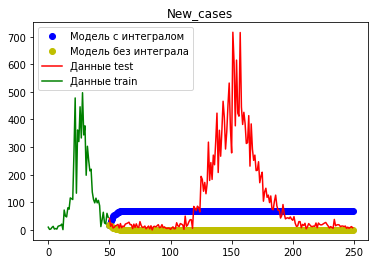

In [ ]:
plt.plot(np.arange(50, 250).reshape(-1, 1), np.cumsum(np.exp(reg.predict(xs_t[:200]))), 'bo', label = 'Модель с интегралом')
plt.plot(np.arange(50, 250).reshape(-1, 1), np.exp(reg.predict(xs_t[:200])), 'yo', label='Модель без интеграла')
plt.plot(np.arange(50, 250).reshape(-1, 1), test_new_cases[:200], 'r', label='Данные test')
plt.plot(np.arange(50).reshape(-1, 1), train_new_cases, color='g',  label='Данные train')
plt.title('New_cases')
plt.legend()
plt.show()

При использовании модели с экспоненциальным ростом были получены завышенные ожидания. При использовании модели с ростом числа заболевших функции распределения для гауссиана результаты можно предсказать на ближайшие несколько дней. Можно заметить, что для Австралии и для России коэффициенты модели похожи, а также score. Таким образом, можно сказать, что модель с сигмоидой предсказывает лучше чем с экспонентой.